#### 背景说明

在农作物生长过程中，病虫害一般发生在叶片、果实、芽和幼枝上。大多数的病虫害都会导致农作物减产。此外，这些病害会导致新的感染，导致大面积的减产。因此，在病害传播到其他作物之前，提前确定病害并采取必要的预防措施是非常重要的。因此，与病虫害作斗争是农业生产中至关重要的问题。<br>
影响农作物的病害有很多种，每种都可能造成经济、社会和生态损失。在此背景下，及时、准确地诊断病害对防止农产品产量和数量的损失具有重要作用。植物病害的检测通常是人工进行的。这些过程由植物学家和农民等专业人员进行，首先通过视觉检查，然后在实验室环境中进行。这些传统方法往往是耗时且复杂的过程。基于这些原因，基于图像处理和深度学习的自动识别病害变得非常重要。用深度学习的方法对植物病害进行自动诊断，对那些对所种植的产品知之甚少或一无所知的用户有很大的帮助。<br>
本项目选取正常和病变的番茄叶图片，训练出能够识别病害叶片的神经网络模型。

#### 示例数据

训练集和验证集分别存储在train和validation两个文件夹下，每个文件夹均包含两个类别：Healthy和Late_blight。Healthy为正常叶片，Late_blight为番茄晚疫病的叶片。
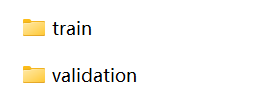
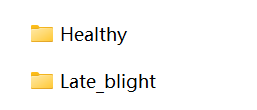


#### 分析思路

用keras的图片生成器对数据进行批次设置、数据增强等操作，然后搭建合适的网络模型对数据进行训练。<br>
1.数据查验。查看各类别图片的数量，选取图片进行展示。<br>
2.图像预处理。利用图像生成器对训练集和验证集进行预处理。<br>
3.模型搭建。搭建二分类神经网络模型。<br>
4.模型训练。用搭建好的网络训练数据集。<br>
5.模型测试。用训练好的模型对陌生图片进行分类。


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import SGD,Adagrad,Adadelta,RMSprop,Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import layers
from keras.models import Sequential

2022-12-29 10:35:57.770823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 10:35:57.770856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 数据查验

In [2]:
# 输出文件夹里的文件数目
print(len(os.listdir('./photo/train/Healthy/')))
print(len(os.listdir('./photo/train/Late_blight/')))
print(len(os.listdir('./photo/validation/Healthy/')))
print(len(os.listdir('./photo/validation/Late_blight/')))

1253
1265
338
343


(256, 256, 3)


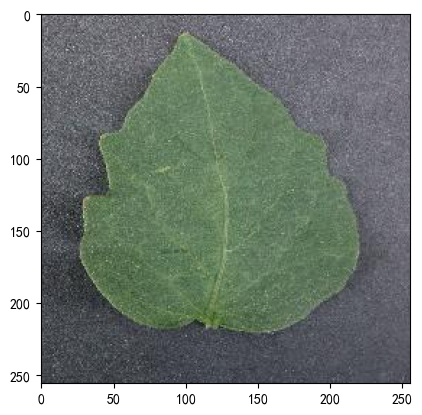

In [3]:
# 查看图像大小

# 选取训练集的一张图片
img_path = './photo/train/Healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG' 
# 读取图片
image = plt.imread(img_path) # 按路径读取图片，并将图片转化为数组
plt.imshow(image) # 展示图片
# 输出图片大小
print(image.shape) 

## 图像预处理（归一化，batch）

In [4]:
# 训练集
train_dir = './photo/train'
#图像预处理
train_datagen = ImageDataGenerator(rescale=1.0/255., # 重缩放因子，像素归一化
                                    rotation_range=45, # 随机旋转的度数范围45
                                    #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    #brightness_range=None,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #channel_shift_range=0.2,
                                    #fill_mode='nearest',
                                    #cval=0.0,
                                    #horizontal_flip=False,
                                  )
#生成一个无限循环产生batch的数据,图像大小设置为150*150
train_generator = train_datagen.flow_from_directory(train_dir, # 训练集路径
                                                    batch_size=50, # 训练批次设置为50
                                                    class_mode='binary', # 标签类型设置为binary
                                                    target_size=(150, 150) # 图像尺寸设置为(150, 150)
                                                   )

Found 2518 images belonging to 2 classes.


In [5]:
#验证集
validation_dir = './photo/validation'
#图像预处理
validation_datagen = ImageDataGenerator(rescale=1.0/255.) # 重缩放因子，像素归一化
#生成一个无限循环产生batch的数据,图像大小设置为150*150
validation_generator = validation_datagen.flow_from_directory(validation_dir, # 验证集路径
                                                              batch_size=20, # 训练批次设置为20
                                                              class_mode='binary', # 标签类型设置为binary
                                                              target_size=(150, 150) # 图像尺寸设置为(150, 150)
                                                             )

Found 681 images belonging to 2 classes.


## 模型搭建

In [6]:
# 搭建网络结构
model = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)), # 2维卷积，激活函数设置为relu
    layers.MaxPool2D(2, 2), # 2维最大池化
    layers.Conv2D(32, (3, 3), activation='relu'), # 2维卷积，激活函数设置为relu
    layers.MaxPool2D(2, 2), # 2维最大池化
    layers.Flatten(), # 平铺层
    layers.Dropout(0.3), # 丢弃部分神经元
    layers.Dense(50, activation='relu'), # 全连接层，激活函数设置为relu
    layers.Dense(1, activation='sigmoid') # 全连接层，sigmoid做激活函数2分类
])
#查看网络层数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dropout (Dropout)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2

2022-12-29 10:35:59.761258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-29 10:35:59.761299: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 10:35:59.761324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iz8vb953cp3j9zt844jqb8z): /proc/driver/nvidia/version does not exist
2022-12-29 10:35:59.761707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# 编译网络模型

model.compile(optimizer=RMSprop(learning_rate=1e-5), # 选取合适的优化器和学习率
              loss='binary_crossentropy', # 损失函数使用二元交叉熵
              metrics=['acc']) # 用准确率做评估

## 模型训练

In [8]:
# 早停
monitor = EarlyStopping(monitor='val_acc', # 检测指标为val_acc
                        min_delta=0.01, # 最小提升度 
                        patience=10, # 训练轮次
                        verbose=1, # 精确模式
                        mode='auto' # 自动识别
                       )

In [9]:
# 模型训练
history = model.fit(train_generator, # 训练集
                    epochs=50, # 训练轮次
                    validation_data=validation_generator, # 验证集
                    callbacks = [monitor] # 提前停止
                             )

2022-12-29 10:36:00.429437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
51/51 [==============================] - 17s 323ms/step - loss: 0.6740 - acc: 0.5719 - val_loss: 0.6282 - val_acc: 0.7342
Epoch 2/50
51/51 [==============================] - 18s 350ms/step - loss: 0.6291 - acc: 0.6962 - val_loss: 0.5724 - val_acc: 0.7254
Epoch 3/50
51/51 [==============================] - 17s 326ms/step - loss: 0.5835 - acc: 0.7423 - val_loss: 0.5365 - val_acc: 0.7283
Epoch 4/50
51/51 [==============================] - 17s 338ms/step - loss: 0.5460 - acc: 0.7629 - val_loss: 0.5072 - val_acc: 0.7372
Epoch 5/50
51/51 [==============================] - 18s 343ms/step - loss: 0.5077 - acc: 0.7855 - val_loss: 0.4410 - val_acc: 0.7885
Epoch 6/50
51/51 [==============================] - 18s 343ms/step - loss: 0.4713 - acc: 0.8018 - val_loss: 0.4412 - val_acc: 0.7709
Epoch 7/50
51/51 [==============================] - 16s 315ms/step - loss: 0.4384 - acc: 0.8360 - val_loss: 0.3856 - val_acc: 0.8355
Epoch 8/50
51/51 [==============================] - 16s 318ms/step - 

#### 准确率和损失值

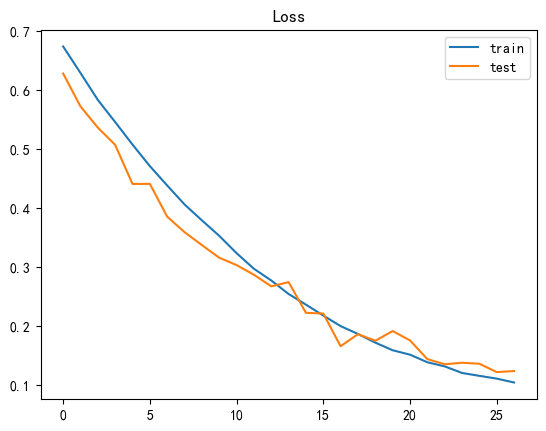

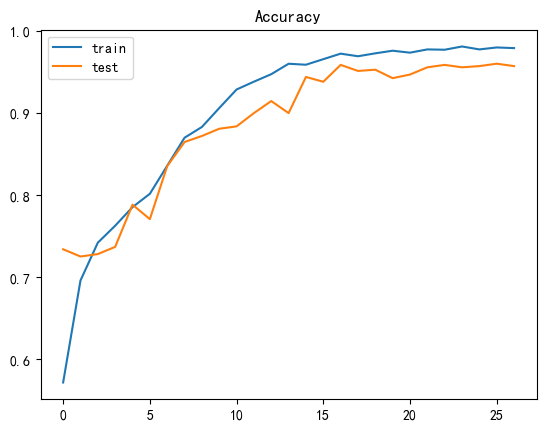

In [10]:
#绘制损失值和准确率曲线

#plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train') #训练集损失
plt.plot(history.history['val_loss'], label='test') #验证集损失
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train') #训练集准确率
plt.plot(history.history['val_acc'], label='test') #验证集准确率
plt.legend()
plt.show()

In [11]:
# 存储模型
model.save('CNN.h5') # 存储模型并命名为CNN

In [12]:
# 加载模型
load_model = load_model('CNN.h5') # 加载模型

## 测试

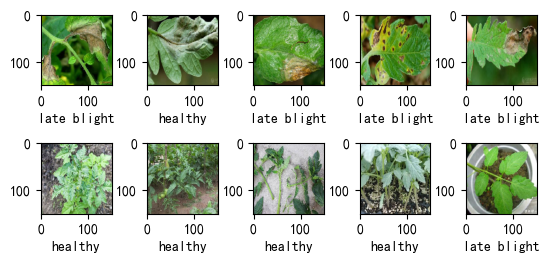

In [13]:
from keras.preprocessing import image
path = './test'
for i,j in enumerate(os.listdir(path)):
    #print(i)
    image_path = os.path.join(path,j) # 路径拼接
    plt.subplot(2, 5, i + 1) # 设置多个子图的个数及位置
    img = image.load_img(image_path, target_size=(150, 150)) # 加载图片，设置图片大小
    x = image.img_to_array(img) # 图片转化为数组
    x = np.expand_dims(x, axis=0) # 扩展数组形状
    images = np.vstack([x]) # 数组堆叠
    images=images/255 # 归一化
    classes = load_model.predict(images, batch_size=10) # 用加载的模型预测

    if classes[0]<0.5:
        plt.xlabel("healthy")
    else: 
        plt.xlabel("late blight")
        
    plt.subplots_adjust(top=0.6, wspace=0.5, hspace=0.2) # 调整子图位置
    plt.imshow(img) # 显示图片
    
    